In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [30]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [18]:
# test = np.random.rand(40, )
# x = torch.tensor(test, dtype=torch.float32)
# print(test.shape)
#test = x.unsqueeze(0)
#print(test)
testing = np.random.rand(64, 1, 40 )
new = np.random.rand(1, 40)
print(new)
x = torch.tensor(testing, dtype=torch.float32)
conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
maxpool = nn.MaxPool1d(kernel_size=2)
dropout = nn.Dropout1d(p=0.5)
flatten = nn.Flatten(0)

relu = nn.ReLU()

# calculate the in_features
fc1 = nn.Linear(in_features=256, out_features=128)
# self.fc1 = nn.Linear(in_features=120, out_features=90)
fc2 = nn.Linear(in_features=128, out_features=10)

x = conv1d(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_2(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_3(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling

print(x.shape)
x = fc1(x)
x = relu(x)
x = fc2(x)

[[0.89791616 0.19238013 0.62945046 0.86316389 0.01735072 0.25639148
  0.85197991 0.38931035 0.85861953 0.10493076 0.90891688 0.06074454
  0.72074641 0.26971217 0.46406514 0.93878079 0.72143353 0.02834914
  0.257736   0.95571597 0.20237624 0.99459999 0.022132   0.34177808
  0.72220885 0.98121747 0.9110368  0.91813289 0.34714199 0.58935928
  0.72662105 0.58097726 0.56131705 0.16763715 0.57973246 0.16043128
  0.2421254  0.61613146 0.42858433 0.91020351]]
torch.Size([64, 64, 19])
torch.Size([64, 128, 7])
torch.Size([64, 256, 2])
torch.Size([64, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 256x128)

In [4]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/process_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/process_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/process_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [7]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [8]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [9]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [10]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 38.01it/s]


Train: Epoch 0: Loss 2.327143907546997, Accuracy 0.10790289256198347
Eval: Epoch 0: Loss 2.3027491569519043, Accuracy 0.1095703125


100%|██████████| 55/55 [00:01<00:00, 46.53it/s]


Train: Epoch 1: Loss 2.329643487930298, Accuracy 0.09320764462809916
Eval: Epoch 1: Loss 2.303004741668701, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 2: Loss 2.3193085193634033, Accuracy 0.0980888429752066
Eval: Epoch 2: Loss 2.302833080291748, Accuracy 0.1103515625


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 3: Loss 2.3166983127593994, Accuracy 0.10007747933884296
Eval: Epoch 3: Loss 2.3038933277130127, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 4: Loss 2.3164970874786377, Accuracy 0.1040289256198347
Eval: Epoch 4: Loss 2.3043391704559326, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 5: Loss 2.3125202655792236, Accuracy 0.10105888429752066
Eval: Epoch 5: Loss 2.3050036430358887, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 6: Loss 2.3103394508361816, Accuracy 0.10111053719008266
Eval: Epoch 6: Loss 2.305367946624756, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 7: Loss 2.3073692321777344, Accuracy 0.11105371900826447
Eval: Epoch 7: Loss 2.305147647857666, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 8: Loss 2.3099215030670166, Accuracy 0.0996900826446281
Eval: Epoch 8: Loss 2.3051862716674805, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 9: Loss 2.310173749923706, Accuracy 0.10785123966942148
Eval: Epoch 9: Loss 2.3053925037384033, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 10: Loss 2.3074748516082764, Accuracy 0.1084452479338843
Eval: Epoch 10: Loss 2.3056540489196777, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 46.36it/s]


Train: Epoch 11: Loss 2.3092238903045654, Accuracy 0.1081611570247934
Eval: Epoch 11: Loss 2.3055131435394287, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 50.78it/s]


Train: Epoch 12: Loss 2.3061885833740234, Accuracy 0.10175619834710745
Eval: Epoch 12: Loss 2.306049346923828, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 13: Loss 2.3065621852874756, Accuracy 0.10320247933884297
Eval: Epoch 13: Loss 2.3065052032470703, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 14: Loss 2.3017737865448, Accuracy 0.11882747933884297
Eval: Epoch 14: Loss 2.3059916496276855, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 15: Loss 2.3015189170837402, Accuracy 0.11513429752066115
Eval: Epoch 15: Loss 2.3065505027770996, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 43.80it/s]


Train: Epoch 16: Loss 2.3089325428009033, Accuracy 0.10149793388429751
Eval: Epoch 16: Loss 2.3066565990448, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 42.87it/s]


Train: Epoch 17: Loss 2.3053290843963623, Accuracy 0.10464876033057852
Eval: Epoch 17: Loss 2.306241989135742, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 47.54it/s]


Train: Epoch 18: Loss 2.3022658824920654, Accuracy 0.10800619834710744
Eval: Epoch 18: Loss 2.3065595626831055, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 35.92it/s]


Train: Epoch 19: Loss 2.3034422397613525, Accuracy 0.10648243801652893
Eval: Epoch 19: Loss 2.3067052364349365, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 36.80it/s]


Train: Epoch 20: Loss 2.307111978530884, Accuracy 0.10080061983471074
Eval: Epoch 20: Loss 2.307037830352783, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 42.70it/s]


Train: Epoch 21: Loss 2.3015456199645996, Accuracy 0.11528925619834711
Eval: Epoch 21: Loss 2.307123899459839, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 45.31it/s]


Train: Epoch 22: Loss 2.2999722957611084, Accuracy 0.1199896694214876
Eval: Epoch 22: Loss 2.306790828704834, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 42.59it/s]


Train: Epoch 23: Loss 2.301459312438965, Accuracy 0.10906508264462811
Eval: Epoch 23: Loss 2.3067076206207275, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 42.94it/s]


Train: Epoch 24: Loss 2.3032705783843994, Accuracy 0.10364152892561983
Eval: Epoch 24: Loss 2.3075332641601562, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 45.44it/s]


Train: Epoch 25: Loss 2.3017220497131348, Accuracy 0.10335743801652893
Eval: Epoch 25: Loss 2.307187080383301, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 42.16it/s]


Train: Epoch 26: Loss 2.302271842956543, Accuracy 0.1103047520661157
Eval: Epoch 26: Loss 2.307215690612793, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 46.50it/s]


Train: Epoch 27: Loss 2.299057960510254, Accuracy 0.10829028925619835
Eval: Epoch 27: Loss 2.3080055713653564, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 51.50it/s]


Train: Epoch 28: Loss 2.30143666267395, Accuracy 0.1074638429752066
Eval: Epoch 28: Loss 2.3077714443206787, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 29: Loss 2.3012125492095947, Accuracy 0.11430785123966943
Eval: Epoch 29: Loss 2.3082222938537598, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 30: Loss 2.302187919616699, Accuracy 0.10888429752066116
Eval: Epoch 30: Loss 2.30774188041687, Accuracy 0.085546875


100%|██████████| 55/55 [00:01<00:00, 49.20it/s]


Train: Epoch 31: Loss 2.3010997772216797, Accuracy 0.11417871900826447
Eval: Epoch 31: Loss 2.3080577850341797, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 50.27it/s]


Train: Epoch 32: Loss 2.2987754344940186, Accuracy 0.11017561983471075
Eval: Epoch 32: Loss 2.3087570667266846, Accuracy 0.0814453125


100%|██████████| 55/55 [00:01<00:00, 51.31it/s]


Train: Epoch 33: Loss 2.3017890453338623, Accuracy 0.11598657024793388
Eval: Epoch 33: Loss 2.30876088142395, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 51.50it/s]


Train: Epoch 34: Loss 2.300093412399292, Accuracy 0.11482438016528926
Eval: Epoch 34: Loss 2.309011459350586, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 35: Loss 2.2997846603393555, Accuracy 0.11526342975206612
Eval: Epoch 35: Loss 2.3094563484191895, Accuracy 0.082421875


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 36: Loss 2.2989447116851807, Accuracy 0.11557334710743801
Eval: Epoch 36: Loss 2.309445858001709, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 37: Loss 2.299424648284912, Accuracy 0.11825929752066115
Eval: Epoch 37: Loss 2.309037685394287, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 38: Loss 2.2946219444274902, Accuracy 0.12135847107438016
Eval: Epoch 38: Loss 2.310410261154175, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 52.38it/s]


Train: Epoch 39: Loss 2.2976138591766357, Accuracy 0.11836260330578512
Eval: Epoch 39: Loss 2.309222936630249, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 40: Loss 2.2961792945861816, Accuracy 0.12332128099173553
Eval: Epoch 40: Loss 2.310680627822876, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 41: Loss 2.294055223464966, Accuracy 0.11454028925619834
Eval: Epoch 41: Loss 2.3102636337280273, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 42: Loss 2.300280809402466, Accuracy 0.11412706611570249
Eval: Epoch 42: Loss 2.3101298809051514, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 48.69it/s]


Train: Epoch 43: Loss 2.2977538108825684, Accuracy 0.11784607438016528
Eval: Epoch 43: Loss 2.310302257537842, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 46.42it/s]


Train: Epoch 44: Loss 2.299121856689453, Accuracy 0.10947830578512396
Eval: Epoch 44: Loss 2.3107805252075195, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 46.50it/s]


Train: Epoch 45: Loss 2.2939555644989014, Accuracy 0.11944731404958678
Eval: Epoch 45: Loss 2.3098745346069336, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 46.18it/s]


Train: Epoch 46: Loss 2.2961220741271973, Accuracy 0.12164256198347108
Eval: Epoch 46: Loss 2.309870719909668, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 47: Loss 2.2963802814483643, Accuracy 0.11577995867768595
Eval: Epoch 47: Loss 2.310822010040283, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 40.50it/s]


Train: Epoch 48: Loss 2.2973837852478027, Accuracy 0.12040289256198347
Eval: Epoch 48: Loss 2.309277057647705, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 43.28it/s]


Train: Epoch 49: Loss 2.296633720397949, Accuracy 0.12249483471074381
Eval: Epoch 49: Loss 2.3088135719299316, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 44.18it/s]


Train: Epoch 50: Loss 2.2949414253234863, Accuracy 0.12729855371900825
Eval: Epoch 50: Loss 2.308243751525879, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 41.89it/s]


Train: Epoch 51: Loss 2.2976725101470947, Accuracy 0.11327479338842976
Eval: Epoch 51: Loss 2.3087193965911865, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 45.95it/s]


Train: Epoch 52: Loss 2.2950212955474854, Accuracy 0.12192665289256198
Eval: Epoch 52: Loss 2.309352397918701, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 46.86it/s]


Train: Epoch 53: Loss 2.2936019897460938, Accuracy 0.11939566115702478
Eval: Epoch 53: Loss 2.3090107440948486, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 49.31it/s]


Train: Epoch 54: Loss 2.2913269996643066, Accuracy 0.12861570247933884
Eval: Epoch 54: Loss 2.3104331493377686, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 55: Loss 2.295466899871826, Accuracy 0.11949896694214876
Eval: Epoch 55: Loss 2.310696840286255, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 56: Loss 2.294450283050537, Accuracy 0.1269111570247934
Eval: Epoch 56: Loss 2.3103127479553223, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 51.26it/s]


Train: Epoch 57: Loss 2.2908647060394287, Accuracy 0.12138429752066116
Eval: Epoch 57: Loss 2.310134172439575, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 58: Loss 2.297564744949341, Accuracy 0.1222107438016529
Eval: Epoch 58: Loss 2.310640573501587, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 59: Loss 2.2943458557128906, Accuracy 0.12110020661157024
Eval: Epoch 59: Loss 2.3104236125946045, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 52.08it/s]


Train: Epoch 60: Loss 2.2928996086120605, Accuracy 0.1293646694214876
Eval: Epoch 60: Loss 2.311194658279419, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 50.93it/s]


Train: Epoch 61: Loss 2.2926430702209473, Accuracy 0.11366219008264462
Eval: Epoch 61: Loss 2.3107612133026123, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 62: Loss 2.28902268409729, Accuracy 0.1271694214876033
Eval: Epoch 62: Loss 2.3128466606140137, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 63: Loss 2.2937352657318115, Accuracy 0.11743285123966943
Eval: Epoch 63: Loss 2.312729835510254, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 49.11it/s]


Train: Epoch 64: Loss 2.2909984588623047, Accuracy 0.12776342975206612
Eval: Epoch 64: Loss 2.3116962909698486, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 65: Loss 2.294137954711914, Accuracy 0.11513429752066115
Eval: Epoch 65: Loss 2.311891794204712, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 51.84it/s]


Train: Epoch 66: Loss 2.291860580444336, Accuracy 0.12915805785123965
Eval: Epoch 66: Loss 2.3127529621124268, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 51.31it/s]


Train: Epoch 67: Loss 2.293527841567993, Accuracy 0.12445764462809916
Eval: Epoch 67: Loss 2.312894582748413, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 50.56it/s]


Train: Epoch 68: Loss 2.2913765907287598, Accuracy 0.11670971074380165
Eval: Epoch 68: Loss 2.3129358291625977, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 69: Loss 2.291890859603882, Accuracy 0.12525826446280994
Eval: Epoch 69: Loss 2.3141379356384277, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 70: Loss 2.291757106781006, Accuracy 0.12737603305785125
Eval: Epoch 70: Loss 2.3144054412841797, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 51.45it/s]


Train: Epoch 71: Loss 2.288309097290039, Accuracy 0.1256198347107438
Eval: Epoch 71: Loss 2.315730571746826, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 49.02it/s]


Train: Epoch 72: Loss 2.2916595935821533, Accuracy 0.12254648760330579
Eval: Epoch 72: Loss 2.3149678707122803, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 73: Loss 2.2896859645843506, Accuracy 0.12450929752066116
Eval: Epoch 73: Loss 2.314709186553955, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 74: Loss 2.2905824184417725, Accuracy 0.12197830578512397
Eval: Epoch 74: Loss 2.315307378768921, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 51.07it/s]


Train: Epoch 75: Loss 2.2908506393432617, Accuracy 0.12766012396694215
Eval: Epoch 75: Loss 2.3142151832580566, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 51.16it/s]


Train: Epoch 76: Loss 2.28674578666687, Accuracy 0.13016528925619836
Eval: Epoch 76: Loss 2.3152213096618652, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 77: Loss 2.287318468093872, Accuracy 0.1365702479338843
Eval: Epoch 77: Loss 2.3156135082244873, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 78: Loss 2.2842156887054443, Accuracy 0.13935950413223142
Eval: Epoch 78: Loss 2.3167521953582764, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 51.35it/s]


Train: Epoch 79: Loss 2.287012815475464, Accuracy 0.12791838842975206
Eval: Epoch 79: Loss 2.3167691230773926, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 80: Loss 2.2886295318603516, Accuracy 0.1290547520661157
Eval: Epoch 80: Loss 2.3162858486175537, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 51.02it/s]


Train: Epoch 81: Loss 2.2893238067626953, Accuracy 0.12479338842975206
Eval: Epoch 81: Loss 2.3158645629882812, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 82: Loss 2.2845427989959717, Accuracy 0.1334194214876033
Eval: Epoch 82: Loss 2.315519094467163, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 83: Loss 2.283182144165039, Accuracy 0.12988119834710743
Eval: Epoch 83: Loss 2.316455841064453, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 84: Loss 2.286094903945923, Accuracy 0.13455578512396693
Eval: Epoch 84: Loss 2.3174400329589844, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 47.60it/s]


Train: Epoch 85: Loss 2.2859315872192383, Accuracy 0.1259039256198347
Eval: Epoch 85: Loss 2.31693696975708, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 86: Loss 2.288330554962158, Accuracy 0.12605888429752066
Eval: Epoch 86: Loss 2.316696882247925, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 49.43it/s]


Train: Epoch 87: Loss 2.2839391231536865, Accuracy 0.1347107438016529
Eval: Epoch 87: Loss 2.317544460296631, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 46.00it/s]


Train: Epoch 88: Loss 2.284403085708618, Accuracy 0.12988119834710743
Eval: Epoch 88: Loss 2.3192291259765625, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 45.69it/s]


Train: Epoch 89: Loss 2.2782256603240967, Accuracy 0.13334194214876033
Eval: Epoch 89: Loss 2.321451187133789, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 46.37it/s]


Train: Epoch 90: Loss 2.284038782119751, Accuracy 0.1324896694214876
Eval: Epoch 90: Loss 2.3210349082946777, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 91: Loss 2.2816622257232666, Accuracy 0.13770661157024794
Eval: Epoch 91: Loss 2.3227972984313965, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 92: Loss 2.2873549461364746, Accuracy 0.12634297520661159
Eval: Epoch 92: Loss 2.3210556507110596, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 47.99it/s]


Train: Epoch 93: Loss 2.2833333015441895, Accuracy 0.131275826446281
Eval: Epoch 93: Loss 2.322127342224121, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 94: Loss 2.2817816734313965, Accuracy 0.1319214876033058
Eval: Epoch 94: Loss 2.3224620819091797, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 47.28it/s]


Train: Epoch 95: Loss 2.2778890132904053, Accuracy 0.14832128099173555
Eval: Epoch 95: Loss 2.3227455615997314, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 46.44it/s]


Train: Epoch 96: Loss 2.278085947036743, Accuracy 0.13959194214876033
Eval: Epoch 96: Loss 2.3231444358825684, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 49.16it/s]


Train: Epoch 97: Loss 2.2802109718322754, Accuracy 0.13788739669421488
Eval: Epoch 97: Loss 2.3216614723205566, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 50.04it/s]


Train: Epoch 98: Loss 2.2808151245117188, Accuracy 0.1324638429752066
Eval: Epoch 98: Loss 2.322924852371216, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 99: Loss 2.2830328941345215, Accuracy 0.12647210743801654
Eval: Epoch 99: Loss 2.321084499359131, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 100: Loss 2.2825167179107666, Accuracy 0.13321280991735537
Eval: Epoch 100: Loss 2.321733236312866, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 101: Loss 2.2788634300231934, Accuracy 0.14098657024793387
Eval: Epoch 101: Loss 2.3195250034332275, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 102: Loss 2.279780626296997, Accuracy 0.1418130165289256
Eval: Epoch 102: Loss 2.321215867996216, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 103: Loss 2.274308204650879, Accuracy 0.1415547520661157
Eval: Epoch 103: Loss 2.321173906326294, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 49.03it/s]


Train: Epoch 104: Loss 2.2791688442230225, Accuracy 0.13145661157024793
Eval: Epoch 104: Loss 2.323124885559082, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 105: Loss 2.276252269744873, Accuracy 0.143698347107438
Eval: Epoch 105: Loss 2.322784185409546, Accuracy 0.08515625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 106: Loss 2.2731146812438965, Accuracy 0.146900826446281
Eval: Epoch 106: Loss 2.322432279586792, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 107: Loss 2.2773289680480957, Accuracy 0.14207128099173552
Eval: Epoch 107: Loss 2.3225901126861572, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 51.64it/s]


Train: Epoch 108: Loss 2.276885747909546, Accuracy 0.14026342975206613
Eval: Epoch 108: Loss 2.3227572441101074, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 109: Loss 2.2762110233306885, Accuracy 0.14351756198347107
Eval: Epoch 109: Loss 2.3218154907226562, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 51.30it/s]


Train: Epoch 110: Loss 2.273963689804077, Accuracy 0.1428719008264463
Eval: Epoch 110: Loss 2.322288990020752, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 111: Loss 2.273906946182251, Accuracy 0.13734504132231404
Eval: Epoch 111: Loss 2.3228769302368164, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 51.69it/s]


Train: Epoch 112: Loss 2.27457332611084, Accuracy 0.14139979338842976
Eval: Epoch 112: Loss 2.3232593536376953, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 44.93it/s]


Train: Epoch 113: Loss 2.2760367393493652, Accuracy 0.14150309917355372
Eval: Epoch 113: Loss 2.3226406574249268, Accuracy 0.0865234375


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 114: Loss 2.2677881717681885, Accuracy 0.1577479338842975
Eval: Epoch 114: Loss 2.3242533206939697, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 115: Loss 2.2675037384033203, Accuracy 0.15348657024793388
Eval: Epoch 115: Loss 2.3264546394348145, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 116: Loss 2.274101972579956, Accuracy 0.1471849173553719
Eval: Epoch 116: Loss 2.326667070388794, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 49.07it/s]


Train: Epoch 117: Loss 2.2705843448638916, Accuracy 0.1350464876033058
Eval: Epoch 117: Loss 2.3252036571502686, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 118: Loss 2.2676422595977783, Accuracy 0.14638429752066115
Eval: Epoch 118: Loss 2.3274645805358887, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 48.98it/s]


Train: Epoch 119: Loss 2.270498752593994, Accuracy 0.13884297520661157
Eval: Epoch 119: Loss 2.3252952098846436, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 120: Loss 2.269989013671875, Accuracy 0.14483471074380166
Eval: Epoch 120: Loss 2.3281795978546143, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 45.91it/s]


Train: Epoch 121: Loss 2.264298915863037, Accuracy 0.1487861570247934
Eval: Epoch 121: Loss 2.326019763946533, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 52.28it/s]


Train: Epoch 122: Loss 2.2639544010162354, Accuracy 0.1509297520661157
Eval: Epoch 122: Loss 2.3272294998168945, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 123: Loss 2.2646267414093018, Accuracy 0.15632747933884297
Eval: Epoch 123: Loss 2.327641487121582, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 124: Loss 2.2644946575164795, Accuracy 0.1472107438016529
Eval: Epoch 124: Loss 2.328460216522217, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 51.12it/s]


Train: Epoch 125: Loss 2.266227960586548, Accuracy 0.14294938016528927
Eval: Epoch 125: Loss 2.3294692039489746, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 44.35it/s]


Train: Epoch 126: Loss 2.262251615524292, Accuracy 0.15100723140495867
Eval: Epoch 126: Loss 2.3322105407714844, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 127: Loss 2.266350507736206, Accuracy 0.14550619834710743
Eval: Epoch 127: Loss 2.333191156387329, Accuracy 0.081640625


100%|██████████| 55/55 [00:01<00:00, 42.60it/s]


Train: Epoch 128: Loss 2.264559268951416, Accuracy 0.1456611570247934
Eval: Epoch 128: Loss 2.330589532852173, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 46.26it/s]


Train: Epoch 129: Loss 2.261457681655884, Accuracy 0.14974173553719008
Eval: Epoch 129: Loss 2.332444190979004, Accuracy 0.0828125


100%|██████████| 55/55 [00:01<00:00, 44.57it/s]


Train: Epoch 130: Loss 2.266211986541748, Accuracy 0.15330578512396695
Eval: Epoch 130: Loss 2.331456422805786, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 35.99it/s]


Train: Epoch 131: Loss 2.2570972442626953, Accuracy 0.15911673553719008
Eval: Epoch 131: Loss 2.3331596851348877, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 42.08it/s]


Train: Epoch 132: Loss 2.256688117980957, Accuracy 0.15428719008264463
Eval: Epoch 132: Loss 2.333048105239868, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 133: Loss 2.2621092796325684, Accuracy 0.14883780991735537
Eval: Epoch 133: Loss 2.3310611248016357, Accuracy 0.0859375


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 134: Loss 2.2576143741607666, Accuracy 0.15526859504132232
Eval: Epoch 134: Loss 2.3339321613311768, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 135: Loss 2.2580833435058594, Accuracy 0.15173037190082644
Eval: Epoch 135: Loss 2.3336727619171143, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 136: Loss 2.260012626647949, Accuracy 0.14666838842975205
Eval: Epoch 136: Loss 2.3347394466400146, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 137: Loss 2.2604029178619385, Accuracy 0.14863119834710742
Eval: Epoch 137: Loss 2.334174871444702, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 51.21it/s]


Train: Epoch 138: Loss 2.2540175914764404, Accuracy 0.16038223140495866
Eval: Epoch 138: Loss 2.3337697982788086, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 139: Loss 2.2524170875549316, Accuracy 0.16144111570247932
Eval: Epoch 139: Loss 2.3337435722351074, Accuracy 0.0873046875


100%|██████████| 55/55 [00:01<00:00, 50.50it/s]


Train: Epoch 140: Loss 2.259392261505127, Accuracy 0.14726239669421487
Eval: Epoch 140: Loss 2.3361711502075195, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 50.27it/s]


Train: Epoch 141: Loss 2.257718086242676, Accuracy 0.1581095041322314
Eval: Epoch 141: Loss 2.3347866535186768, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 142: Loss 2.252121686935425, Accuracy 0.16428202479338844
Eval: Epoch 142: Loss 2.336832046508789, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 143: Loss 2.256324291229248, Accuracy 0.15699896694214877
Eval: Epoch 143: Loss 2.3375701904296875, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 50.69it/s]


Train: Epoch 144: Loss 2.256166696548462, Accuracy 0.15715392561983468
Eval: Epoch 144: Loss 2.3377273082733154, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 145: Loss 2.2587878704071045, Accuracy 0.1583935950413223
Eval: Epoch 145: Loss 2.336397409439087, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 146: Loss 2.2549889087677, Accuracy 0.1603047520661157
Eval: Epoch 146: Loss 2.336576223373413, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 51.26it/s]


Train: Epoch 147: Loss 2.255371332168579, Accuracy 0.15237603305785125
Eval: Epoch 147: Loss 2.337052345275879, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 148: Loss 2.2561872005462646, Accuracy 0.15178202479338843
Eval: Epoch 148: Loss 2.338083267211914, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 51.12it/s]


Train: Epoch 149: Loss 2.2476160526275635, Accuracy 0.15862603305785125
Eval: Epoch 149: Loss 2.3379948139190674, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 150: Loss 2.2449634075164795, Accuracy 0.15769628099173555
Eval: Epoch 150: Loss 2.3388257026672363, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 48.42it/s]


Train: Epoch 151: Loss 2.2477166652679443, Accuracy 0.15428719008264463
Eval: Epoch 151: Loss 2.3401596546173096, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 51.84it/s]


Train: Epoch 152: Loss 2.2493865489959717, Accuracy 0.15885847107438014
Eval: Epoch 152: Loss 2.338693141937256, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 51.59it/s]


Train: Epoch 153: Loss 2.2465953826904297, Accuracy 0.1621126033057851
Eval: Epoch 153: Loss 2.3411970138549805, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 154: Loss 2.2463347911834717, Accuracy 0.16087293388429752
Eval: Epoch 154: Loss 2.3450241088867188, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 50.93it/s]


Train: Epoch 155: Loss 2.2471823692321777, Accuracy 0.1603047520661157
Eval: Epoch 155: Loss 2.3440310955047607, Accuracy 0.0888671875


100%|██████████| 55/55 [00:01<00:00, 51.50it/s]


Train: Epoch 156: Loss 2.242764472961426, Accuracy 0.16213842975206613
Eval: Epoch 156: Loss 2.343564033508301, Accuracy 0.0857421875


100%|██████████| 55/55 [00:01<00:00, 51.99it/s]


Train: Epoch 157: Loss 2.246859312057495, Accuracy 0.1646694214876033
Eval: Epoch 157: Loss 2.3396575450897217, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 50.78it/s]


Train: Epoch 158: Loss 2.246493339538574, Accuracy 0.16425619834710742
Eval: Epoch 158: Loss 2.3401081562042236, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 51.79it/s]


Train: Epoch 159: Loss 2.242506265640259, Accuracy 0.16368801652892562
Eval: Epoch 159: Loss 2.342702627182007, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 51.94it/s]


Train: Epoch 160: Loss 2.2410547733306885, Accuracy 0.15893595041322314
Eval: Epoch 160: Loss 2.3436031341552734, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 50.78it/s]


Train: Epoch 161: Loss 2.244514226913452, Accuracy 0.17252066115702477
Eval: Epoch 161: Loss 2.3468194007873535, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 162: Loss 2.2405622005462646, Accuracy 0.165599173553719
Eval: Epoch 162: Loss 2.3460559844970703, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 51.74it/s]


Train: Epoch 163: Loss 2.2440645694732666, Accuracy 0.17135847107438015
Eval: Epoch 163: Loss 2.347235679626465, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 164: Loss 2.2489700317382812, Accuracy 0.16255165289256196
Eval: Epoch 164: Loss 2.3486082553863525, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 165: Loss 2.238304376602173, Accuracy 0.17445764462809918
Eval: Epoch 165: Loss 2.34749436378479, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 49.51it/s]


Train: Epoch 166: Loss 2.2445504665374756, Accuracy 0.16270661157024793
Eval: Epoch 166: Loss 2.3480496406555176, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 167: Loss 2.237605571746826, Accuracy 0.17678202479338842
Eval: Epoch 167: Loss 2.349703073501587, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 168: Loss 2.2405717372894287, Accuracy 0.1690599173553719
Eval: Epoch 168: Loss 2.3476083278656006, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 169: Loss 2.2408089637756348, Accuracy 0.16753615702479338
Eval: Epoch 169: Loss 2.351353883743286, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 50.36it/s]


Train: Epoch 170: Loss 2.238974094390869, Accuracy 0.17050619834710742
Eval: Epoch 170: Loss 2.3483524322509766, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 171: Loss 2.232489824295044, Accuracy 0.1677944214876033
Eval: Epoch 171: Loss 2.3494601249694824, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 172: Loss 2.2406961917877197, Accuracy 0.1690599173553719
Eval: Epoch 172: Loss 2.346776247024536, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 51.02it/s]


Train: Epoch 173: Loss 2.229116916656494, Accuracy 0.17688533057851238
Eval: Epoch 173: Loss 2.349816083908081, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 51.84it/s]


Train: Epoch 174: Loss 2.2343006134033203, Accuracy 0.18117252066115702
Eval: Epoch 174: Loss 2.3477180004119873, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 175: Loss 2.2311015129089355, Accuracy 0.16924070247933884
Eval: Epoch 175: Loss 2.349245548248291, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 176: Loss 2.235558032989502, Accuracy 0.1668130165289256
Eval: Epoch 176: Loss 2.35042405128479, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 177: Loss 2.2387850284576416, Accuracy 0.1756198347107438
Eval: Epoch 177: Loss 2.3494198322296143, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 51.21it/s]


Train: Epoch 178: Loss 2.2303717136383057, Accuracy 0.17616219008264464
Eval: Epoch 178: Loss 2.3509230613708496, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 179: Loss 2.233757734298706, Accuracy 0.16428202479338844
Eval: Epoch 179: Loss 2.3530163764953613, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 180: Loss 2.2319087982177734, Accuracy 0.1714876033057851
Eval: Epoch 180: Loss 2.3532540798187256, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 51.84it/s]


Train: Epoch 181: Loss 2.2274158000946045, Accuracy 0.18326446280991737
Eval: Epoch 181: Loss 2.354362964630127, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 51.55it/s]


Train: Epoch 182: Loss 2.2304160594940186, Accuracy 0.1774793388429752
Eval: Epoch 182: Loss 2.3541369438171387, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 51.89it/s]


Train: Epoch 183: Loss 2.2337310314178467, Accuracy 0.17050619834710742
Eval: Epoch 183: Loss 2.356201648712158, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 184: Loss 2.222728967666626, Accuracy 0.17897727272727273
Eval: Epoch 184: Loss 2.3574185371398926, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 50.92it/s]


Train: Epoch 185: Loss 2.2242965698242188, Accuracy 0.18316115702479338
Eval: Epoch 185: Loss 2.3553483486175537, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 51.35it/s]


Train: Epoch 186: Loss 2.2194981575012207, Accuracy 0.18114669421487603
Eval: Epoch 186: Loss 2.3567981719970703, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 187: Loss 2.221642255783081, Accuracy 0.18514979338842977
Eval: Epoch 187: Loss 2.3586933612823486, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.41it/s]


Train: Epoch 188: Loss 2.224047899246216, Accuracy 0.1765754132231405
Eval: Epoch 188: Loss 2.3608169555664062, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 189: Loss 2.219057321548462, Accuracy 0.1822055785123967
Eval: Epoch 189: Loss 2.3592681884765625, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 190: Loss 2.2241809368133545, Accuracy 0.17889979338842976
Eval: Epoch 190: Loss 2.359565496444702, Accuracy 0.1080078125


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 191: Loss 2.2184038162231445, Accuracy 0.19462809917355373
Eval: Epoch 191: Loss 2.3582041263580322, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 192: Loss 2.2259953022003174, Accuracy 0.17357954545454546
Eval: Epoch 192: Loss 2.359786033630371, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 51.69it/s]


Train: Epoch 193: Loss 2.2167701721191406, Accuracy 0.18416838842975206
Eval: Epoch 193: Loss 2.3600683212280273, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 194: Loss 2.2186832427978516, Accuracy 0.18254132231404957
Eval: Epoch 194: Loss 2.3613603115081787, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 195: Loss 2.2168307304382324, Accuracy 0.17913223140495865
Eval: Epoch 195: Loss 2.360760450363159, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 196: Loss 2.2266223430633545, Accuracy 0.17097107438016532
Eval: Epoch 196: Loss 2.3607778549194336, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 197: Loss 2.2165980339050293, Accuracy 0.1802685950413223
Eval: Epoch 197: Loss 2.3638172149658203, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 53.29it/s]


Train: Epoch 198: Loss 2.2112255096435547, Accuracy 0.1862861570247934
Eval: Epoch 198: Loss 2.3635826110839844, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 51.07it/s]


Train: Epoch 199: Loss 2.2115883827209473, Accuracy 0.18907541322314048
Eval: Epoch 199: Loss 2.363837718963623, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 200: Loss 2.2076499462127686, Accuracy 0.1868285123966942
Eval: Epoch 200: Loss 2.362950563430786, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 201: Loss 2.211846113204956, Accuracy 0.18274793388429753
Eval: Epoch 201: Loss 2.3614823818206787, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 202: Loss 2.21433424949646, Accuracy 0.17644628099173554
Eval: Epoch 202: Loss 2.3613221645355225, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 51.94it/s]


Train: Epoch 203: Loss 2.2106218338012695, Accuracy 0.19080578512396693
Eval: Epoch 203: Loss 2.364071846008301, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 51.64it/s]


Train: Epoch 204: Loss 2.213496685028076, Accuracy 0.18383264462809917
Eval: Epoch 204: Loss 2.366804838180542, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.50it/s]


Train: Epoch 205: Loss 2.2114200592041016, Accuracy 0.18739669421487604
Eval: Epoch 205: Loss 2.3648455142974854, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 51.89it/s]


Train: Epoch 206: Loss 2.206480026245117, Accuracy 0.18907541322314048
Eval: Epoch 206: Loss 2.36189603805542, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 207: Loss 2.211132764816284, Accuracy 0.18664772727272727
Eval: Epoch 207: Loss 2.365633010864258, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 51.94it/s]


Train: Epoch 208: Loss 2.204674482345581, Accuracy 0.19356921487603307
Eval: Epoch 208: Loss 2.3694634437561035, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 209: Loss 2.202101469039917, Accuracy 0.18326446280991737
Eval: Epoch 209: Loss 2.3703839778900146, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 51.69it/s]


Train: Epoch 210: Loss 2.2036352157592773, Accuracy 0.17740185950413223
Eval: Epoch 210: Loss 2.372170925140381, Accuracy 0.1068359375


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 211: Loss 2.2014055252075195, Accuracy 0.1943181818181818
Eval: Epoch 211: Loss 2.3729135990142822, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 212: Loss 2.1954843997955322, Accuracy 0.199974173553719
Eval: Epoch 212: Loss 2.3715133666992188, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.22it/s]


Train: Epoch 213: Loss 2.202134609222412, Accuracy 0.18197314049586777
Eval: Epoch 213: Loss 2.3748362064361572, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 214: Loss 2.205010175704956, Accuracy 0.18605371900826445
Eval: Epoch 214: Loss 2.3703572750091553, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 215: Loss 2.198070764541626, Accuracy 0.20297004132231405
Eval: Epoch 215: Loss 2.3740074634552, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 216: Loss 2.201565742492676, Accuracy 0.18205061983471077
Eval: Epoch 216: Loss 2.3727307319641113, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 46.23it/s]


Train: Epoch 217: Loss 2.1952779293060303, Accuracy 0.19863119834710743
Eval: Epoch 217: Loss 2.3717780113220215, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 46.45it/s]


Train: Epoch 218: Loss 2.2006280422210693, Accuracy 0.1915289256198347
Eval: Epoch 218: Loss 2.375265121459961, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 51.16it/s]


Train: Epoch 219: Loss 2.190185070037842, Accuracy 0.19266528925619833
Eval: Epoch 219: Loss 2.3741776943206787, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 220: Loss 2.1983325481414795, Accuracy 0.19204545454545455
Eval: Epoch 220: Loss 2.3769819736480713, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 221: Loss 2.1965034008026123, Accuracy 0.19674586776859504
Eval: Epoch 221: Loss 2.372847080230713, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 49.41it/s]


Train: Epoch 222: Loss 2.195835590362549, Accuracy 0.1946539256198347
Eval: Epoch 222: Loss 2.3760735988616943, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 49.55it/s]


Train: Epoch 223: Loss 2.1939852237701416, Accuracy 0.19922520661157025
Eval: Epoch 223: Loss 2.380906820297241, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 224: Loss 2.1933469772338867, Accuracy 0.19803719008264464
Eval: Epoch 224: Loss 2.3749260902404785, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 225: Loss 2.1952812671661377, Accuracy 0.20229855371900826
Eval: Epoch 225: Loss 2.3793728351593018, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 226: Loss 2.1991140842437744, Accuracy 0.19090909090909092
Eval: Epoch 226: Loss 2.3806204795837402, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 227: Loss 2.1959311962127686, Accuracy 0.19586776859504135
Eval: Epoch 227: Loss 2.3813576698303223, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 228: Loss 2.191092014312744, Accuracy 0.19194214876033058
Eval: Epoch 228: Loss 2.3785531520843506, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 229: Loss 2.183333158493042, Accuracy 0.20346074380165288
Eval: Epoch 229: Loss 2.3816709518432617, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 230: Loss 2.1908485889434814, Accuracy 0.20059400826446283
Eval: Epoch 230: Loss 2.384134292602539, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 231: Loss 2.1942138671875, Accuracy 0.19380165289256196
Eval: Epoch 231: Loss 2.3857460021972656, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 232: Loss 2.189323663711548, Accuracy 0.1940857438016529
Eval: Epoch 232: Loss 2.385291337966919, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 51.12it/s]


Train: Epoch 233: Loss 2.189842939376831, Accuracy 0.19917355371900827
Eval: Epoch 233: Loss 2.382035732269287, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 50.50it/s]


Train: Epoch 234: Loss 2.1841514110565186, Accuracy 0.2087293388429752
Eval: Epoch 234: Loss 2.3828725814819336, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 48.42it/s]


Train: Epoch 235: Loss 2.184353828430176, Accuracy 0.19434400826446283
Eval: Epoch 235: Loss 2.3893887996673584, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 236: Loss 2.1870079040527344, Accuracy 0.1993543388429752
Eval: Epoch 236: Loss 2.389547348022461, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 52.28it/s]


Train: Epoch 237: Loss 2.1818950176239014, Accuracy 0.19832128099173554
Eval: Epoch 237: Loss 2.386690139770508, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 238: Loss 2.1910877227783203, Accuracy 0.1940599173553719
Eval: Epoch 238: Loss 2.384901285171509, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 239: Loss 2.187368154525757, Accuracy 0.20260847107438015
Eval: Epoch 239: Loss 2.384599447250366, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 240: Loss 2.187044382095337, Accuracy 0.19829545454545455
Eval: Epoch 240: Loss 2.386988878250122, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 241: Loss 2.1869983673095703, Accuracy 0.1965650826446281
Eval: Epoch 241: Loss 2.3930954933166504, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 242: Loss 2.179168939590454, Accuracy 0.19899276859504134
Eval: Epoch 242: Loss 2.392098903656006, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 243: Loss 2.1826558113098145, Accuracy 0.19721074380165288
Eval: Epoch 243: Loss 2.394047737121582, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 51.16it/s]


Train: Epoch 244: Loss 2.181614398956299, Accuracy 0.19573863636363636
Eval: Epoch 244: Loss 2.391871452331543, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 245: Loss 2.1706175804138184, Accuracy 0.21350723140495867
Eval: Epoch 245: Loss 2.3922781944274902, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 246: Loss 2.167863130569458, Accuracy 0.2099431818181818
Eval: Epoch 246: Loss 2.3903167247772217, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 49.11it/s]


Train: Epoch 247: Loss 2.1733391284942627, Accuracy 0.21363636363636362
Eval: Epoch 247: Loss 2.394113302230835, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 248: Loss 2.1755661964416504, Accuracy 0.2071797520661157
Eval: Epoch 248: Loss 2.3923492431640625, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 249: Loss 2.1730000972747803, Accuracy 0.20697314049586776
Eval: Epoch 249: Loss 2.3940329551696777, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 51.12it/s]


Train: Epoch 250: Loss 2.1747806072235107, Accuracy 0.20142045454545454
Eval: Epoch 250: Loss 2.3956809043884277, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 251: Loss 2.173964023590088, Accuracy 0.2013688016528926
Eval: Epoch 251: Loss 2.394425392150879, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 252: Loss 2.1708285808563232, Accuracy 0.2115702479338843
Eval: Epoch 252: Loss 2.400038719177246, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 48.85it/s]


Train: Epoch 253: Loss 2.1753618717193604, Accuracy 0.20457128099173555
Eval: Epoch 253: Loss 2.3972909450531006, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 254: Loss 2.17022442817688, Accuracy 0.21043388429752066
Eval: Epoch 254: Loss 2.3959031105041504, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 40.71it/s]


Train: Epoch 255: Loss 2.1677968502044678, Accuracy 0.20947830578512397
Eval: Epoch 255: Loss 2.4013495445251465, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 38.39it/s]


Train: Epoch 256: Loss 2.1658244132995605, Accuracy 0.21293904958677684
Eval: Epoch 256: Loss 2.4020934104919434, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 31.74it/s]


Train: Epoch 257: Loss 2.174055576324463, Accuracy 0.21355888429752068
Eval: Epoch 257: Loss 2.3951752185821533, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 40.83it/s]


Train: Epoch 258: Loss 2.166659355163574, Accuracy 0.21224173553719008
Eval: Epoch 258: Loss 2.3988895416259766, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 46.73it/s]


Train: Epoch 259: Loss 2.1633358001708984, Accuracy 0.21149276859504135
Eval: Epoch 259: Loss 2.401487112045288, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 260: Loss 2.1697871685028076, Accuracy 0.20896177685950412
Eval: Epoch 260: Loss 2.4014124870300293, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 261: Loss 2.1710708141326904, Accuracy 0.2120867768595041
Eval: Epoch 261: Loss 2.401303291320801, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 47.21it/s]


Train: Epoch 262: Loss 2.1654932498931885, Accuracy 0.21278409090909092
Eval: Epoch 262: Loss 2.4023468494415283, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 263: Loss 2.157539129257202, Accuracy 0.22636880165289258
Eval: Epoch 263: Loss 2.4060373306274414, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 264: Loss 2.169782876968384, Accuracy 0.19948347107438016
Eval: Epoch 264: Loss 2.405075788497925, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 48.68it/s]


Train: Epoch 265: Loss 2.1655631065368652, Accuracy 0.21118285123966943
Eval: Epoch 265: Loss 2.4063332080841064, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 266: Loss 2.1579604148864746, Accuracy 0.21169938016528925
Eval: Epoch 266: Loss 2.4014408588409424, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 267: Loss 2.1583330631256104, Accuracy 0.21596074380165287
Eval: Epoch 267: Loss 2.403848648071289, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 45.91it/s]


Train: Epoch 268: Loss 2.1708500385284424, Accuracy 0.20769628099173554
Eval: Epoch 268: Loss 2.400574207305908, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 269: Loss 2.1670734882354736, Accuracy 0.2065082644628099
Eval: Epoch 269: Loss 2.4046976566314697, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 47.37it/s]


Train: Epoch 270: Loss 2.1575541496276855, Accuracy 0.2228305785123967
Eval: Epoch 270: Loss 2.4031951427459717, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 271: Loss 2.1565194129943848, Accuracy 0.21451446280991737
Eval: Epoch 271: Loss 2.404848098754883, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 272: Loss 2.164006233215332, Accuracy 0.21735537190082646
Eval: Epoch 272: Loss 2.402859687805176, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 273: Loss 2.1600759029388428, Accuracy 0.21451446280991737
Eval: Epoch 273: Loss 2.406877279281616, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 274: Loss 2.1523056030273438, Accuracy 0.20932334710743802
Eval: Epoch 274: Loss 2.411198139190674, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 275: Loss 2.147341728210449, Accuracy 0.22360537190082647
Eval: Epoch 275: Loss 2.4077415466308594, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 276: Loss 2.146817922592163, Accuracy 0.21291322314049588
Eval: Epoch 276: Loss 2.413553237915039, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 277: Loss 2.1536307334899902, Accuracy 0.2119318181818182
Eval: Epoch 277: Loss 2.414154052734375, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 278: Loss 2.1480348110198975, Accuracy 0.21278409090909092
Eval: Epoch 278: Loss 2.4198668003082275, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 279: Loss 2.1507561206817627, Accuracy 0.21420454545454545
Eval: Epoch 279: Loss 2.4185221195220947, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 280: Loss 2.1339735984802246, Accuracy 0.23605371900826447
Eval: Epoch 280: Loss 2.4165494441986084, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 281: Loss 2.141879081726074, Accuracy 0.22197830578512398
Eval: Epoch 281: Loss 2.4188947677612305, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 282: Loss 2.151975154876709, Accuracy 0.21875
Eval: Epoch 282: Loss 2.420377731323242, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 43.21it/s]


Train: Epoch 283: Loss 2.1400203704833984, Accuracy 0.22642045454545454
Eval: Epoch 283: Loss 2.4248154163360596, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 284: Loss 2.1399030685424805, Accuracy 0.22254648760330578
Eval: Epoch 284: Loss 2.42364764213562, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 42.02it/s]


Train: Epoch 285: Loss 2.1420164108276367, Accuracy 0.22673037190082646
Eval: Epoch 285: Loss 2.4243862628936768, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 286: Loss 2.144576072692871, Accuracy 0.225025826446281
Eval: Epoch 286: Loss 2.425416946411133, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 287: Loss 2.1454825401306152, Accuracy 0.21707128099173553
Eval: Epoch 287: Loss 2.4219069480895996, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 288: Loss 2.135352611541748, Accuracy 0.22143595041322314
Eval: Epoch 288: Loss 2.4257068634033203, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 48.89it/s]


Train: Epoch 289: Loss 2.1309893131256104, Accuracy 0.22773760330578513
Eval: Epoch 289: Loss 2.427462339401245, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 290: Loss 2.1376614570617676, Accuracy 0.2233987603305785
Eval: Epoch 290: Loss 2.423031806945801, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 41.98it/s]


Train: Epoch 291: Loss 2.140064001083374, Accuracy 0.21766528925619832
Eval: Epoch 291: Loss 2.427229166030884, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 42.64it/s]


Train: Epoch 292: Loss 2.141472339630127, Accuracy 0.22443181818181818
Eval: Epoch 292: Loss 2.4207704067230225, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 44.25it/s]


Train: Epoch 293: Loss 2.1324872970581055, Accuracy 0.22081611570247933
Eval: Epoch 293: Loss 2.4256680011749268, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 41.86it/s]


Train: Epoch 294: Loss 2.1366970539093018, Accuracy 0.2211776859504132
Eval: Epoch 294: Loss 2.42254376411438, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 45.87it/s]


Train: Epoch 295: Loss 2.1382105350494385, Accuracy 0.22295971074380166
Eval: Epoch 295: Loss 2.4232821464538574, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 296: Loss 2.128108024597168, Accuracy 0.23073347107438016
Eval: Epoch 296: Loss 2.4246599674224854, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 297: Loss 2.138242244720459, Accuracy 0.22564566115702478
Eval: Epoch 297: Loss 2.425712823867798, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 44.72it/s]


Train: Epoch 298: Loss 2.13150691986084, Accuracy 0.22825413223140498
Eval: Epoch 298: Loss 2.419257640838623, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 44.97it/s]


Train: Epoch 299: Loss 2.1321229934692383, Accuracy 0.21926652892561985
Eval: Epoch 299: Loss 2.4250926971435547, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 300: Loss 2.1266636848449707, Accuracy 0.23352272727272727
Eval: Epoch 300: Loss 2.4267563819885254, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 301: Loss 2.1267292499542236, Accuracy 0.23765495867768593
Eval: Epoch 301: Loss 2.4287302494049072, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 47.17it/s]


Train: Epoch 302: Loss 2.1220428943634033, Accuracy 0.23228305785123968
Eval: Epoch 302: Loss 2.4295003414154053, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 303: Loss 2.116734743118286, Accuracy 0.231275826446281
Eval: Epoch 303: Loss 2.4315614700317383, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 48.41it/s]


Train: Epoch 304: Loss 2.1186611652374268, Accuracy 0.23765495867768593
Eval: Epoch 304: Loss 2.4289608001708984, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 305: Loss 2.119647264480591, Accuracy 0.22657541322314048
Eval: Epoch 305: Loss 2.4333858489990234, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 306: Loss 2.1258742809295654, Accuracy 0.23109504132231407
Eval: Epoch 306: Loss 2.435258150100708, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 48.98it/s]


Train: Epoch 307: Loss 2.1284358501434326, Accuracy 0.231275826446281
Eval: Epoch 307: Loss 2.440276861190796, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 37.69it/s]


Train: Epoch 308: Loss 2.122229814529419, Accuracy 0.2416064049586777
Eval: Epoch 308: Loss 2.4347808361053467, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 28.23it/s]


Train: Epoch 309: Loss 2.1188769340515137, Accuracy 0.2324380165289256
Eval: Epoch 309: Loss 2.434908866882324, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 30.14it/s]


Train: Epoch 310: Loss 2.1198015213012695, Accuracy 0.23285123966942148
Eval: Epoch 310: Loss 2.4306387901306152, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 37.47it/s]


Train: Epoch 311: Loss 2.104055881500244, Accuracy 0.23682851239669422
Eval: Epoch 311: Loss 2.4437506198883057, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 42.83it/s]


Train: Epoch 312: Loss 2.117340087890625, Accuracy 0.24248450413223138
Eval: Epoch 312: Loss 2.4423699378967285, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 45.87it/s]


Train: Epoch 313: Loss 2.1189184188842773, Accuracy 0.22629132231404958
Eval: Epoch 313: Loss 2.441254138946533, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 46.03it/s]


Train: Epoch 314: Loss 2.1162712574005127, Accuracy 0.23285123966942148
Eval: Epoch 314: Loss 2.437560796737671, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 315: Loss 2.112197160720825, Accuracy 0.2409349173553719
Eval: Epoch 315: Loss 2.4362545013427734, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 316: Loss 2.120673179626465, Accuracy 0.2341167355371901
Eval: Epoch 316: Loss 2.4466214179992676, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 317: Loss 2.1090826988220215, Accuracy 0.24532541322314047
Eval: Epoch 317: Loss 2.4460601806640625, Accuracy 0.10859375


100%|██████████| 55/55 [00:01<00:00, 47.17it/s]


Train: Epoch 318: Loss 2.1093552112579346, Accuracy 0.23884297520661157
Eval: Epoch 318: Loss 2.446073055267334, Accuracy 0.104296875


100%|██████████| 55/55 [00:01<00:00, 45.22it/s]


Train: Epoch 319: Loss 2.1180531978607178, Accuracy 0.2296745867768595
Eval: Epoch 319: Loss 2.442462921142578, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 320: Loss 2.1010897159576416, Accuracy 0.23070764462809917
Eval: Epoch 320: Loss 2.4444639682769775, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 321: Loss 2.104982376098633, Accuracy 0.24395661157024795
Eval: Epoch 321: Loss 2.4415013790130615, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 322: Loss 2.1059365272521973, Accuracy 0.24385330578512396
Eval: Epoch 322: Loss 2.4425737857818604, Accuracy 0.10703125


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 323: Loss 2.1105005741119385, Accuracy 0.23236053719008262
Eval: Epoch 323: Loss 2.4444844722747803, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 47.01it/s]


Train: Epoch 324: Loss 2.1083781719207764, Accuracy 0.24199380165289258
Eval: Epoch 324: Loss 2.4434077739715576, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 325: Loss 2.103321075439453, Accuracy 0.24165805785123967
Eval: Epoch 325: Loss 2.4513635635375977, Accuracy 0.107421875


100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Train: Epoch 326: Loss 2.1058454513549805, Accuracy 0.23143078512396695
Eval: Epoch 326: Loss 2.4497811794281006, Accuracy 0.112890625


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 327: Loss 2.1145079135894775, Accuracy 0.22856404958677684
Eval: Epoch 327: Loss 2.44673228263855, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 48.85it/s]


Train: Epoch 328: Loss 2.1035897731781006, Accuracy 0.2413223140495868
Eval: Epoch 328: Loss 2.4473607540130615, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 329: Loss 2.110055446624756, Accuracy 0.23241219008264463
Eval: Epoch 329: Loss 2.4480857849121094, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 330: Loss 2.0982823371887207, Accuracy 0.24232954545454546
Eval: Epoch 330: Loss 2.449918746948242, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Train: Epoch 331: Loss 2.0960299968719482, Accuracy 0.24369834710743804
Eval: Epoch 331: Loss 2.4522244930267334, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 45.80it/s]


Train: Epoch 332: Loss 2.0903754234313965, Accuracy 0.24956095041322315
Eval: Epoch 332: Loss 2.4514994621276855, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 41.94it/s]


Train: Epoch 333: Loss 2.1008942127227783, Accuracy 0.24039256198347106
Eval: Epoch 333: Loss 2.4526970386505127, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 45.18it/s]


Train: Epoch 334: Loss 2.103489637374878, Accuracy 0.23019111570247933
Eval: Epoch 334: Loss 2.4496963024139404, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 46.99it/s]


Train: Epoch 335: Loss 2.0944809913635254, Accuracy 0.2566632231404959
Eval: Epoch 335: Loss 2.45516300201416, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 336: Loss 2.087019443511963, Accuracy 0.25015495867768595
Eval: Epoch 336: Loss 2.4578757286071777, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 337: Loss 2.093162775039673, Accuracy 0.2399793388429752
Eval: Epoch 337: Loss 2.455589532852173, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 44.53it/s]


Train: Epoch 338: Loss 2.1054697036743164, Accuracy 0.23664772727272726
Eval: Epoch 338: Loss 2.454282760620117, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 47.87it/s]


Train: Epoch 339: Loss 2.0888657569885254, Accuracy 0.24790805785123968
Eval: Epoch 339: Loss 2.4568850994110107, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 340: Loss 2.087702751159668, Accuracy 0.25
Eval: Epoch 340: Loss 2.4611361026763916, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 341: Loss 2.087979555130005, Accuracy 0.24612603305785125
Eval: Epoch 341: Loss 2.4655630588531494, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 342: Loss 2.0901455879211426, Accuracy 0.2487345041322314
Eval: Epoch 342: Loss 2.4574873447418213, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 343: Loss 2.0956010818481445, Accuracy 0.24741735537190082
Eval: Epoch 343: Loss 2.4647915363311768, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 344: Loss 2.095160722732544, Accuracy 0.24762396694214875
Eval: Epoch 344: Loss 2.4683597087860107, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 345: Loss 2.0779097080230713, Accuracy 0.2524535123966942
Eval: Epoch 345: Loss 2.4620089530944824, Accuracy 0.1064453125


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 346: Loss 2.087697982788086, Accuracy 0.24431818181818182
Eval: Epoch 346: Loss 2.4636447429656982, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 347: Loss 2.0819993019104004, Accuracy 0.2474948347107438
Eval: Epoch 347: Loss 2.4709980487823486, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 348: Loss 2.092005729675293, Accuracy 0.23068181818181818
Eval: Epoch 348: Loss 2.464186668395996, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 49.19it/s]


Train: Epoch 349: Loss 2.0898234844207764, Accuracy 0.23494318181818183
Eval: Epoch 349: Loss 2.466334342956543, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 49.46it/s]


Train: Epoch 350: Loss 2.077120065689087, Accuracy 0.25836776859504135
Eval: Epoch 350: Loss 2.471885919570923, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.41it/s]


Train: Epoch 351: Loss 2.0870020389556885, Accuracy 0.24367252066115702
Eval: Epoch 351: Loss 2.461390733718872, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 352: Loss 2.0805115699768066, Accuracy 0.25105888429752066
Eval: Epoch 352: Loss 2.4684958457946777, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 49.46it/s]


Train: Epoch 353: Loss 2.0830557346343994, Accuracy 0.25015495867768595
Eval: Epoch 353: Loss 2.4707133769989014, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 354: Loss 2.0723156929016113, Accuracy 0.2523760330578512
Eval: Epoch 354: Loss 2.474794387817383, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 45.38it/s]


Train: Epoch 355: Loss 2.086700201034546, Accuracy 0.24643595041322316
Eval: Epoch 355: Loss 2.470451831817627, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 46.49it/s]


Train: Epoch 356: Loss 2.0833964347839355, Accuracy 0.2596074380165289
Eval: Epoch 356: Loss 2.470282793045044, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 357: Loss 2.0635640621185303, Accuracy 0.25875516528925624
Eval: Epoch 357: Loss 2.4745075702667236, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 358: Loss 2.0690407752990723, Accuracy 0.2609504132231405
Eval: Epoch 358: Loss 2.4743335247039795, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 49.50it/s]


Train: Epoch 359: Loss 2.079833984375, Accuracy 0.24736570247933884
Eval: Epoch 359: Loss 2.4742214679718018, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 44.63it/s]


Train: Epoch 360: Loss 2.0686497688293457, Accuracy 0.25046487603305784
Eval: Epoch 360: Loss 2.480116605758667, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 40.77it/s]


Train: Epoch 361: Loss 2.065312623977661, Accuracy 0.25795454545454544
Eval: Epoch 361: Loss 2.4813668727874756, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 44.39it/s]


Train: Epoch 362: Loss 2.0706253051757812, Accuracy 0.2452995867768595
Eval: Epoch 362: Loss 2.4827866554260254, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 363: Loss 2.0574452877044678, Accuracy 0.26270661157024794
Eval: Epoch 363: Loss 2.4767541885375977, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 364: Loss 2.060591459274292, Accuracy 0.25170454545454546
Eval: Epoch 364: Loss 2.480950355529785, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 365: Loss 2.0593128204345703, Accuracy 0.26022727272727275
Eval: Epoch 365: Loss 2.4875569343566895, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 45.05it/s]


Train: Epoch 366: Loss 2.063558578491211, Accuracy 0.25686983471074376
Eval: Epoch 366: Loss 2.4812119007110596, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 45.53it/s]


Train: Epoch 367: Loss 2.0658047199249268, Accuracy 0.26188016528925623
Eval: Epoch 367: Loss 2.493036985397339, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 44.39it/s]


Train: Epoch 368: Loss 2.0550284385681152, Accuracy 0.2620867768595041
Eval: Epoch 368: Loss 2.4852941036224365, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 369: Loss 2.075190782546997, Accuracy 0.25983987603305786
Eval: Epoch 369: Loss 2.4846901893615723, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 39.12it/s]


Train: Epoch 370: Loss 2.0640294551849365, Accuracy 0.2662448347107438
Eval: Epoch 370: Loss 2.4804320335388184, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 32.22it/s]


Train: Epoch 371: Loss 2.0622458457946777, Accuracy 0.25867768595041324
Eval: Epoch 371: Loss 2.4828805923461914, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 37.67it/s]


Train: Epoch 372: Loss 2.065131664276123, Accuracy 0.25891012396694213
Eval: Epoch 372: Loss 2.478027820587158, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 373: Loss 2.059152364730835, Accuracy 0.2644369834710744
Eval: Epoch 373: Loss 2.4831626415252686, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 44.82it/s]


Train: Epoch 374: Loss 2.0533804893493652, Accuracy 0.27223657024793385
Eval: Epoch 374: Loss 2.489885091781616, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 43.14it/s]


Train: Epoch 375: Loss 2.0499355792999268, Accuracy 0.265625
Eval: Epoch 375: Loss 2.488382577896118, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 45.72it/s]


Train: Epoch 376: Loss 2.066061496734619, Accuracy 0.2545454545454545
Eval: Epoch 376: Loss 2.486598491668701, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 44.79it/s]


Train: Epoch 377: Loss 2.0420267581939697, Accuracy 0.27050619834710743
Eval: Epoch 377: Loss 2.48656964302063, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 378: Loss 2.0608437061309814, Accuracy 0.2483987603305785
Eval: Epoch 378: Loss 2.491624593734741, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 379: Loss 2.0565826892852783, Accuracy 0.2650568181818182
Eval: Epoch 379: Loss 2.493976354598999, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 380: Loss 2.0497183799743652, Accuracy 0.2702995867768595
Eval: Epoch 380: Loss 2.4925320148468018, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 381: Loss 2.056138038635254, Accuracy 0.26802685950413224
Eval: Epoch 381: Loss 2.4960522651672363, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 382: Loss 2.0431480407714844, Accuracy 0.26451446280991736
Eval: Epoch 382: Loss 2.4955174922943115, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 383: Loss 2.0518336296081543, Accuracy 0.2513688016528926
Eval: Epoch 383: Loss 2.493980646133423, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 44.53it/s]


Train: Epoch 384: Loss 2.0518136024475098, Accuracy 0.262525826446281
Eval: Epoch 384: Loss 2.4913082122802734, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 39.17it/s]


Train: Epoch 385: Loss 2.0473129749298096, Accuracy 0.26732954545454546
Eval: Epoch 385: Loss 2.494150400161743, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 37.85it/s]


Train: Epoch 386: Loss 2.0581400394439697, Accuracy 0.2538997933884298
Eval: Epoch 386: Loss 2.488006591796875, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 43.89it/s]


Train: Epoch 387: Loss 2.051121234893799, Accuracy 0.2682076446280992
Eval: Epoch 387: Loss 2.5020670890808105, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 44.68it/s]


Train: Epoch 388: Loss 2.056156873703003, Accuracy 0.2678719008264463
Eval: Epoch 388: Loss 2.496851921081543, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 51.74it/s]


Train: Epoch 389: Loss 2.0419418811798096, Accuracy 0.2653667355371901
Eval: Epoch 389: Loss 2.5005784034729004, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 390: Loss 2.0361926555633545, Accuracy 0.2732438016528926
Eval: Epoch 390: Loss 2.496161460876465, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 51.21it/s]


Train: Epoch 391: Loss 2.0491199493408203, Accuracy 0.2618026859504132
Eval: Epoch 391: Loss 2.4971070289611816, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 51.79it/s]


Train: Epoch 392: Loss 2.0474350452423096, Accuracy 0.26239669421487605
Eval: Epoch 392: Loss 2.4893951416015625, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 51.79it/s]


Train: Epoch 393: Loss 2.0458381175994873, Accuracy 0.26668388429752066
Eval: Epoch 393: Loss 2.4918859004974365, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 48.59it/s]


Train: Epoch 394: Loss 2.040419101715088, Accuracy 0.2619059917355372
Eval: Epoch 394: Loss 2.496906042098999, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 50.69it/s]


Train: Epoch 395: Loss 2.0405616760253906, Accuracy 0.265573347107438
Eval: Epoch 395: Loss 2.5021185874938965, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 396: Loss 2.0260090827941895, Accuracy 0.26859504132231404
Eval: Epoch 396: Loss 2.496443748474121, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 397: Loss 2.032043218612671, Accuracy 0.27084194214876034
Eval: Epoch 397: Loss 2.50750470161438, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 52.13it/s]


Train: Epoch 398: Loss 2.019918441772461, Accuracy 0.2765237603305785
Eval: Epoch 398: Loss 2.5080082416534424, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 399: Loss 2.0256357192993164, Accuracy 0.28052685950413225
Eval: Epoch 399: Loss 2.5070879459381104, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 45.49it/s]


Train: Epoch 400: Loss 2.0388455390930176, Accuracy 0.2566632231404959
Eval: Epoch 400: Loss 2.5063724517822266, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 46.45it/s]


Train: Epoch 401: Loss 2.025374174118042, Accuracy 0.27456095041322315
Eval: Epoch 401: Loss 2.5035808086395264, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 402: Loss 2.031583309173584, Accuracy 0.28052685950413225
Eval: Epoch 402: Loss 2.5060195922851562, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 51.35it/s]


Train: Epoch 403: Loss 2.0227298736572266, Accuracy 0.2712551652892562
Eval: Epoch 403: Loss 2.500885009765625, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 51.99it/s]


Train: Epoch 404: Loss 2.029318332672119, Accuracy 0.26947314049586774
Eval: Epoch 404: Loss 2.511906623840332, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 405: Loss 2.022209405899048, Accuracy 0.2715909090909091
Eval: Epoch 405: Loss 2.5102596282958984, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 44.15it/s]


Train: Epoch 406: Loss 2.023691415786743, Accuracy 0.2759814049586777
Eval: Epoch 406: Loss 2.5101101398468018, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 407: Loss 2.0216064453125, Accuracy 0.27982954545454547
Eval: Epoch 407: Loss 2.5042667388916016, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 36.45it/s]


Train: Epoch 408: Loss 2.0162670612335205, Accuracy 0.2791064049586777
Eval: Epoch 408: Loss 2.508181095123291, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 40.98it/s]


Train: Epoch 409: Loss 2.019070625305176, Accuracy 0.28768078512396694
Eval: Epoch 409: Loss 2.516232967376709, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 38.14it/s]


Train: Epoch 410: Loss 2.014787197113037, Accuracy 0.2916064049586777
Eval: Epoch 410: Loss 2.513986110687256, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 42.90it/s]


Train: Epoch 411: Loss 2.0202183723449707, Accuracy 0.2792097107438017
Eval: Epoch 411: Loss 2.511277914047241, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 52.23it/s]


Train: Epoch 412: Loss 2.021280527114868, Accuracy 0.2790289256198347
Eval: Epoch 412: Loss 2.510939836502075, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 49.46it/s]


Train: Epoch 413: Loss 2.0189735889434814, Accuracy 0.2759039256198347
Eval: Epoch 413: Loss 2.509398937225342, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 41.60it/s]


Train: Epoch 414: Loss 2.016803026199341, Accuracy 0.2792097107438017
Eval: Epoch 414: Loss 2.5170037746429443, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 41.32it/s]


Train: Epoch 415: Loss 2.0181884765625, Accuracy 0.2824121900826446
Eval: Epoch 415: Loss 2.521524429321289, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 47.17it/s]


Train: Epoch 416: Loss 2.014164447784424, Accuracy 0.284245867768595
Eval: Epoch 416: Loss 2.5190813541412354, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 417: Loss 2.013198137283325, Accuracy 0.28742252066115703
Eval: Epoch 417: Loss 2.5157241821289062, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 49.55it/s]


Train: Epoch 418: Loss 2.0210564136505127, Accuracy 0.27724690082644626
Eval: Epoch 418: Loss 2.5171947479248047, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 51.50it/s]


Train: Epoch 419: Loss 2.006873607635498, Accuracy 0.28292871900826444
Eval: Epoch 419: Loss 2.522970199584961, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 49.20it/s]


Train: Epoch 420: Loss 2.010122299194336, Accuracy 0.28824896694214874
Eval: Epoch 420: Loss 2.524209499359131, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 50.55it/s]


Train: Epoch 421: Loss 2.011309862136841, Accuracy 0.2715909090909091
Eval: Epoch 421: Loss 2.5252292156219482, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 50.04it/s]


Train: Epoch 422: Loss 2.0144107341766357, Accuracy 0.2784865702479339
Eval: Epoch 422: Loss 2.527250289916992, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 423: Loss 2.0125162601470947, Accuracy 0.28569214876033056
Eval: Epoch 423: Loss 2.5143566131591797, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 424: Loss 2.010406494140625, Accuracy 0.2765754132231405
Eval: Epoch 424: Loss 2.519503593444824, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 425: Loss 2.012117624282837, Accuracy 0.2881714876033058
Eval: Epoch 425: Loss 2.52000093460083, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 40.03it/s]


Train: Epoch 426: Loss 2.0086193084716797, Accuracy 0.2850464876033058
Eval: Epoch 426: Loss 2.522749900817871, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 43.89it/s]


Train: Epoch 427: Loss 2.015270709991455, Accuracy 0.27698863636363635
Eval: Epoch 427: Loss 2.5211572647094727, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 51.45it/s]


Train: Epoch 428: Loss 2.0048720836639404, Accuracy 0.29101239669421486
Eval: Epoch 428: Loss 2.522305727005005, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 429: Loss 1.993600606918335, Accuracy 0.28793904958677685
Eval: Epoch 429: Loss 2.5193169116973877, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 430: Loss 1.9975478649139404, Accuracy 0.2890237603305785
Eval: Epoch 430: Loss 2.5211737155914307, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 51.02it/s]


Train: Epoch 431: Loss 2.002906322479248, Accuracy 0.27985537190082643
Eval: Epoch 431: Loss 2.522386074066162, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 432: Loss 1.9933669567108154, Accuracy 0.29129648760330573
Eval: Epoch 432: Loss 2.528735399246216, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 51.74it/s]


Train: Epoch 433: Loss 2.005169153213501, Accuracy 0.2831095041322314
Eval: Epoch 433: Loss 2.5297513008117676, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 48.42it/s]


Train: Epoch 434: Loss 1.9937258958816528, Accuracy 0.2819473140495868
Eval: Epoch 434: Loss 2.5248985290527344, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 51.21it/s]


Train: Epoch 435: Loss 1.9991965293884277, Accuracy 0.2934659090909091
Eval: Epoch 435: Loss 2.5267913341522217, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 436: Loss 2.0007243156433105, Accuracy 0.2834969008264463
Eval: Epoch 436: Loss 2.530025005340576, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 437: Loss 2.000925302505493, Accuracy 0.2827221074380165
Eval: Epoch 437: Loss 2.5304014682769775, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 438: Loss 1.985357403755188, Accuracy 0.28966942148760333
Eval: Epoch 438: Loss 2.538770914077759, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 439: Loss 2.000330924987793, Accuracy 0.28308367768595044
Eval: Epoch 439: Loss 2.532963991165161, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 51.59it/s]


Train: Epoch 440: Loss 1.993696928024292, Accuracy 0.2940599173553719
Eval: Epoch 440: Loss 2.5360403060913086, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 441: Loss 1.9920798540115356, Accuracy 0.28468491735537194
Eval: Epoch 441: Loss 2.5311384201049805, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 442: Loss 1.9944909811019897, Accuracy 0.2890237603305785
Eval: Epoch 442: Loss 2.538036346435547, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 443: Loss 1.9841828346252441, Accuracy 0.29235537190082644
Eval: Epoch 443: Loss 2.5396502017974854, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 444: Loss 1.9908071756362915, Accuracy 0.29372417355371905
Eval: Epoch 444: Loss 2.5406136512756348, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 49.41it/s]


Train: Epoch 445: Loss 1.9935615062713623, Accuracy 0.2850206611570248
Eval: Epoch 445: Loss 2.538853645324707, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 50.93it/s]


Train: Epoch 446: Loss 1.9923733472824097, Accuracy 0.29114152892561984
Eval: Epoch 446: Loss 2.5438904762268066, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 447: Loss 1.989567518234253, Accuracy 0.2898243801652892
Eval: Epoch 447: Loss 2.5346851348876953, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 448: Loss 1.988616704940796, Accuracy 0.2893078512396694
Eval: Epoch 448: Loss 2.5432231426239014, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 449: Loss 1.9891787767410278, Accuracy 0.2889979338842975
Eval: Epoch 449: Loss 2.540372610092163, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 46.49it/s]


Train: Epoch 450: Loss 1.967223882675171, Accuracy 0.31260330578512396
Eval: Epoch 450: Loss 2.5458667278289795, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 43.69it/s]


Train: Epoch 451: Loss 1.9862442016601562, Accuracy 0.28892045454545456
Eval: Epoch 451: Loss 2.5474631786346436, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 40.65it/s]


Train: Epoch 452: Loss 1.992389440536499, Accuracy 0.2840134297520661
Eval: Epoch 452: Loss 2.542672634124756, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 31.04it/s]


Train: Epoch 453: Loss 1.9741235971450806, Accuracy 0.30710227272727275
Eval: Epoch 453: Loss 2.5478811264038086, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 38.33it/s]


Train: Epoch 454: Loss 1.9973751306533813, Accuracy 0.30113636363636365
Eval: Epoch 454: Loss 2.5492987632751465, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 43.38it/s]


Train: Epoch 455: Loss 1.9917453527450562, Accuracy 0.28690599173553716
Eval: Epoch 455: Loss 2.546095848083496, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 44.35it/s]


Train: Epoch 456: Loss 1.9682796001434326, Accuracy 0.3
Eval: Epoch 456: Loss 2.5507185459136963, Accuracy 0.0884765625


100%|██████████| 55/55 [00:01<00:00, 46.69it/s]


Train: Epoch 457: Loss 1.9856510162353516, Accuracy 0.28824896694214874
Eval: Epoch 457: Loss 2.536168098449707, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 458: Loss 1.9658756256103516, Accuracy 0.30227272727272725
Eval: Epoch 458: Loss 2.5452847480773926, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 49.41it/s]


Train: Epoch 459: Loss 1.97968327999115, Accuracy 0.2943181818181818
Eval: Epoch 459: Loss 2.5466480255126953, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 460: Loss 1.977212905883789, Accuracy 0.2957902892561984
Eval: Epoch 460: Loss 2.5394742488861084, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 44.68it/s]


Train: Epoch 461: Loss 1.9607653617858887, Accuracy 0.30676652892561984
Eval: Epoch 461: Loss 2.5451273918151855, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 40.95it/s]


Train: Epoch 462: Loss 1.9674208164215088, Accuracy 0.30025826446280995
Eval: Epoch 462: Loss 2.556272029876709, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 463: Loss 1.9703490734100342, Accuracy 0.30888429752066116
Eval: Epoch 463: Loss 2.5459415912628174, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 464: Loss 1.9618213176727295, Accuracy 0.29888946280991735
Eval: Epoch 464: Loss 2.558373212814331, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 46.37it/s]


Train: Epoch 465: Loss 1.9643707275390625, Accuracy 0.29888946280991735
Eval: Epoch 465: Loss 2.550854444503784, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 466: Loss 1.964095115661621, Accuracy 0.29134814049586777
Eval: Epoch 466: Loss 2.5521750450134277, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 467: Loss 1.9696465730667114, Accuracy 0.29770144628099177
Eval: Epoch 467: Loss 2.547847270965576, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 468: Loss 1.969582200050354, Accuracy 0.29362086776859503
Eval: Epoch 468: Loss 2.551447868347168, Accuracy 0.0880859375


100%|██████████| 55/55 [00:01<00:00, 46.68it/s]


Train: Epoch 469: Loss 1.9572668075561523, Accuracy 0.30594008264462813
Eval: Epoch 469: Loss 2.5573630332946777, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 44.03it/s]


Train: Epoch 470: Loss 1.9525812864303589, Accuracy 0.31247417355371904
Eval: Epoch 470: Loss 2.547740936279297, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 471: Loss 1.9603145122528076, Accuracy 0.29558367768595045
Eval: Epoch 471: Loss 2.557483673095703, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 48.42it/s]


Train: Epoch 472: Loss 1.9544519186019897, Accuracy 0.3053202479338843
Eval: Epoch 472: Loss 2.5618362426757812, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 473: Loss 1.9571013450622559, Accuracy 0.3037706611570248
Eval: Epoch 473: Loss 2.5639913082122803, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 47.99it/s]


Train: Epoch 474: Loss 1.9420794248580933, Accuracy 0.315625
Eval: Epoch 474: Loss 2.5606279373168945, Accuracy 0.086328125


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 475: Loss 1.957339882850647, Accuracy 0.31278409090909093
Eval: Epoch 475: Loss 2.564862012863159, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 50.36it/s]


Train: Epoch 476: Loss 1.9622907638549805, Accuracy 0.3048553719008264
Eval: Epoch 476: Loss 2.5695788860321045, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 477: Loss 1.9580694437026978, Accuracy 0.31208677685950414
Eval: Epoch 477: Loss 2.565993547439575, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 478: Loss 1.948570966720581, Accuracy 0.3116219008264463
Eval: Epoch 478: Loss 2.5653390884399414, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 479: Loss 1.9510160684585571, Accuracy 0.3050878099173554
Eval: Epoch 479: Loss 2.5661940574645996, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 480: Loss 1.926516056060791, Accuracy 0.3285898760330579
Eval: Epoch 480: Loss 2.5626180171966553, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 49.02it/s]


Train: Epoch 481: Loss 1.9530905485153198, Accuracy 0.30464876033057847
Eval: Epoch 481: Loss 2.56900954246521, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 482: Loss 1.9454962015151978, Accuracy 0.315444214876033
Eval: Epoch 482: Loss 2.572927474975586, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 483: Loss 1.942534327507019, Accuracy 0.3099948347107438
Eval: Epoch 483: Loss 2.571043014526367, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 484: Loss 1.9519444704055786, Accuracy 0.3083419421487603
Eval: Epoch 484: Loss 2.5641889572143555, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 485: Loss 1.9418115615844727, Accuracy 0.3114152892561984
Eval: Epoch 485: Loss 2.5773324966430664, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 486: Loss 1.949358344078064, Accuracy 0.30389979338842976
Eval: Epoch 486: Loss 2.5734646320343018, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 49.51it/s]


Train: Epoch 487: Loss 1.9379088878631592, Accuracy 0.3171229338842975
Eval: Epoch 487: Loss 2.5730552673339844, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 41.94it/s]


Train: Epoch 488: Loss 1.93589448928833, Accuracy 0.30658574380165293
Eval: Epoch 488: Loss 2.583752155303955, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 41.32it/s]


Train: Epoch 489: Loss 1.9463750123977661, Accuracy 0.29318181818181815
Eval: Epoch 489: Loss 2.5794572830200195, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 42.74it/s]


Train: Epoch 490: Loss 1.9415080547332764, Accuracy 0.30183367768595043
Eval: Epoch 490: Loss 2.579275369644165, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 36.54it/s]


Train: Epoch 491: Loss 1.9389002323150635, Accuracy 0.31820764462809914
Eval: Epoch 491: Loss 2.5878491401672363, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 36.64it/s]


Train: Epoch 492: Loss 1.9508566856384277, Accuracy 0.3034607438016529
Eval: Epoch 492: Loss 2.5816807746887207, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 37.49it/s]


Train: Epoch 493: Loss 1.9591736793518066, Accuracy 0.3089101239669421
Eval: Epoch 493: Loss 2.582345485687256, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 494: Loss 1.929517388343811, Accuracy 0.32381198347107437
Eval: Epoch 494: Loss 2.5854313373565674, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 46.69it/s]


Train: Epoch 495: Loss 1.9342997074127197, Accuracy 0.31686466942148755
Eval: Epoch 495: Loss 2.587003231048584, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 41.98it/s]


Train: Epoch 496: Loss 1.9315764904022217, Accuracy 0.3075154958677686
Eval: Epoch 496: Loss 2.5866401195526123, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 42.41it/s]


Train: Epoch 497: Loss 1.9339543581008911, Accuracy 0.31828512396694214
Eval: Epoch 497: Loss 2.579490900039673, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 44.61it/s]


Train: Epoch 498: Loss 1.9300614595413208, Accuracy 0.32195247933884297
Eval: Epoch 498: Loss 2.5873889923095703, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 47.14it/s]


Train: Epoch 499: Loss 1.9462363719940186, Accuracy 0.3074638429752066
Eval: Epoch 499: Loss 2.5884318351745605, Accuracy 0.0951171875


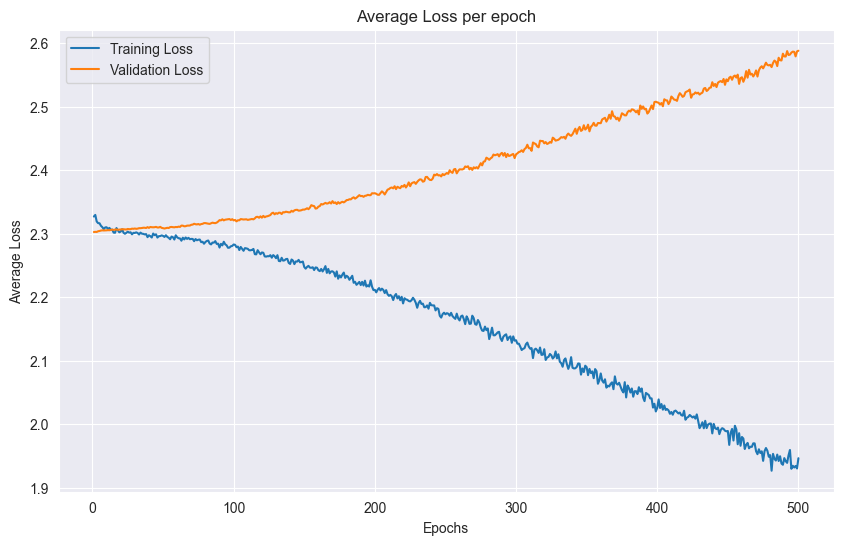

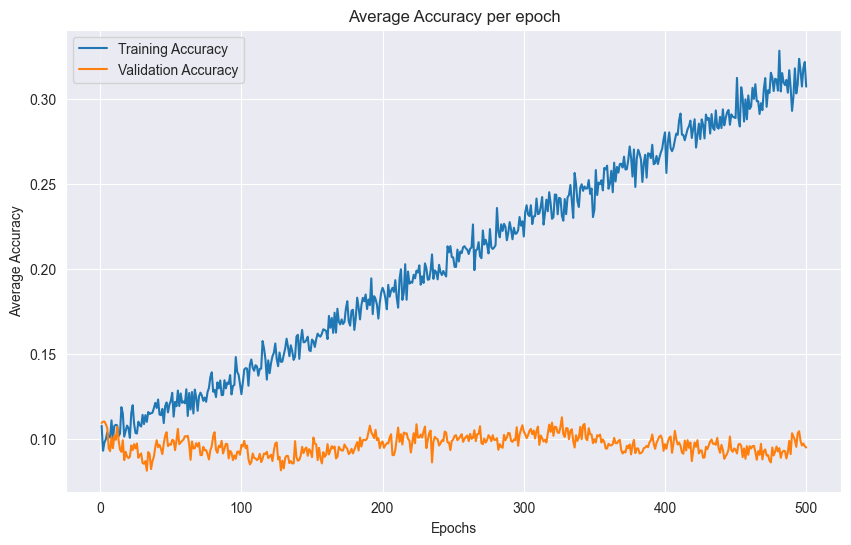

Overall Accuracy: 0.100


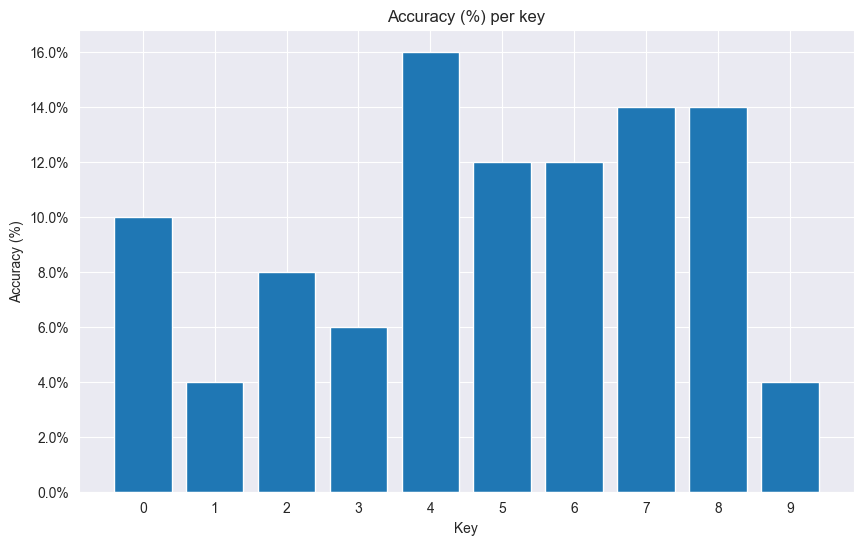

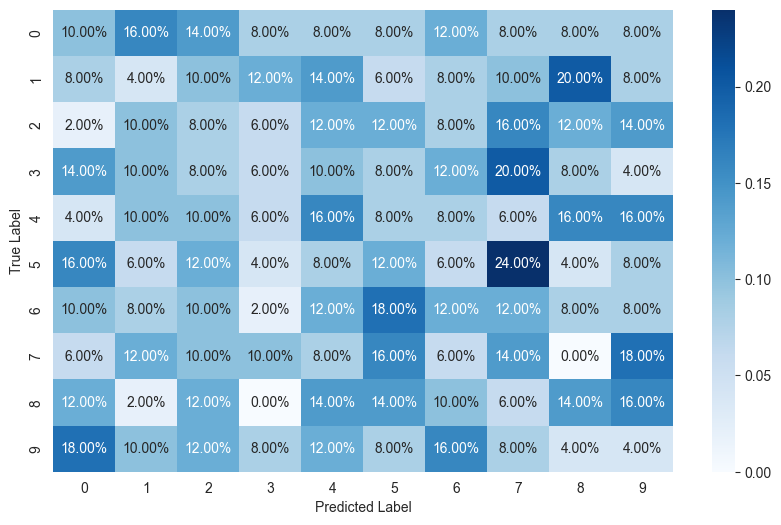

Accuracy for each key: 0: 10.0% 1: 4.0% 2: 8.0% 3: 6.0% 4: 16.0% 5: 12.0% 6: 12.0% 7: 14.0% 8: 14.0% 9: 4.0% 
              precision    recall  f1-score   support

           0       0.10      0.10      0.10        50
           1       0.05      0.04      0.04        50
           2       0.08      0.08      0.08        50
           3       0.10      0.06      0.07        50
           4       0.14      0.16      0.15        50
           5       0.11      0.12      0.11        50
           6       0.12      0.12      0.12        50
           7       0.11      0.14      0.12        50
           8       0.15      0.14      0.14        50
           9       0.04      0.04      0.04        50

    accuracy                           0.10       500
   macro avg       0.10      0.10      0.10       500
weighted avg       0.10      0.10      0.10       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 

In [34]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 500
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    lr = [0.001, 0.0001, 0.00001]
    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    loss = nn.CrossEntropyLoss()
    # train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    # output = []
    # for i in range(len(lr)):
    #     model = CNN1D(number_of_categories)
    #     optimizer = optim.Adam(model.parameters(), lr=lr[i], weight_decay=0.0001)
    #     loss = nn.CrossEntropyLoss()
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     output.append(eval_acc_list)
    #     
    # fig, acc = plt.subplots(figsize=(10,6))
    # x = [i for i in range(1, epochs+1)]
    # for i in range(len(output)):
    #     acc.plot(x, [trainAcc.item() for trainAcc in output[i]])
    # plt.legend()
    # plt.show()
    
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    # torch.save(model.state_dict(), 'model_final.pth')
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()